<a href="https://colab.research.google.com/github/MariosGvr/Pytorch-notebooks-and-resources/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

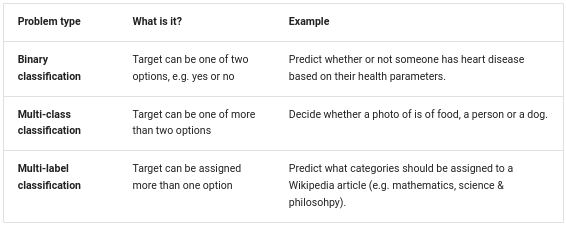

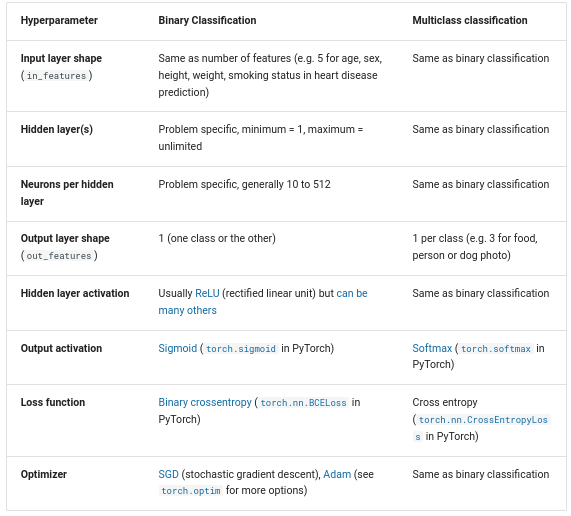

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [2]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                       'X2' : X[:, 1],
                       'label' : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


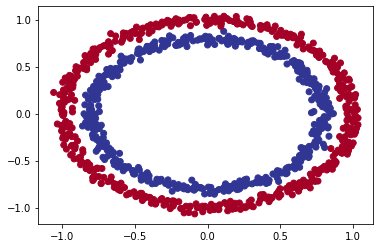

In [4]:
# Visualize x3
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
import torch

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # we are changing the numpy default float64 to pytorch
y = torch.from_numpy(y).type(torch.float) # default float32 because it may cause problems downstream

In [10]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
First 5 samples of y:
 tensor([1., 1., 1., 1., 0.])


In [11]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test), n_samples

(800, 200, 800, 200, 1000)

## 2. Building a model

Let's build a model to classify our blue and red dots.

TO do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model by (subclassing `nn.Module`
3. Define a loss function and optimizer
4. Create a training and test loop

In [13]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we have created device agnostic code, let;s create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that oulines the forward pass (or forward computation) of the model
4. Instatiate an istance of our model class and send it to the target `device`

In [15]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create two nn.Linear layers that are capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2,     # takes in 2 features and upscales to 5 features
                                 out_features=5)    # More hidden features -> easier to learn
        self.layer_2 = nn.Linear(in_features=5,     # takes in 5 features and upscales to 1 feature
                                 out_features=1)    # Output layer
    
    # 3. Define a forward() method that oulines the forward pass (or forward computation) of the model
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> (goes into) layer 1 -> layer 2 -> output

# 4. Instatiate an istance of our model class and send it to the target device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# Where our parameters are
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.1116,  0.6084],
                      [ 0.2990, -0.1269],
                      [-0.5273,  0.2490],
                      [ 0.2757, -0.4481],
                      [-0.5583,  0.4965]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4668,  0.6015,  0.3664, -0.3295,  0.0713], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4185,  0.4102,  0.2452, -0.0022, -0.1110]], device='cuda:0')),
             ('1.bias', tensor([-0.3901], device='cuda:0'))])

In [19]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'Lengths of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Lengths of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 predictions rounded:\n{torch.round(untrained_preds[:10])}')

print(f'\nFirst 10 labels:\n{y_test[:10]}')

Lengths of predictions: 200, Shape: torch.Size([200, 1])
Lengths of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.4637],
        [-0.5437],
        [-0.1674],
        [-0.5480],
        [-0.0299],
        [-0.0798],
        [-0.4141],
        [-0.3051],
        [-0.1736],
        [-0.5476]], device='cuda:0')

First 10 predictions rounded:
tensor([[-0.],
        [-1.],
        [-0.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [20]:
X_test[:10], y_test[:10] 

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

Regression -> MAE or MSE.

Classification -> Binary Cross Entropy / Categorical Cross Entropy.


A loss function measures how wrong your results are.

Logit in DL -> A Logit function, also known as the log-odds function, is a function that represents probability values from 0 to 1, and negative infinity to infinity. The function is an inverse to the sigmoid function that limits values between 0 and 1 across the Y-axis, rather than the X-axis. Because the Logit function exists within the domain of 0 to 1, the function is most commonly used in understanding probabilities. 

In context of deep learning the logits layer means the layer that feeds in to softmax (or other such normalization). The output of the softmax are the probabilities for the classification task and its input is logits layer. The logits layer typically produces values from -infinity to +infinity and the softmax layer transforms it to values from 0 to 1.

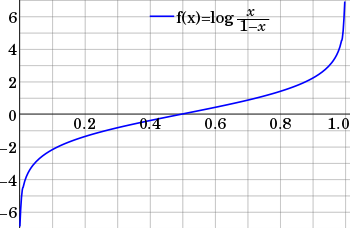

We wil use:
* for the loss function the `torch.nn.BECWithLogitsLoss()`
* for optim

-Loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

-Optimizers: https://pytorch.org/docs/stable/optim.html

In [21]:
# Setup the loss function
#loss_fn = nn.BCEWLoss() # BCEWLoss = Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built=in
                                 # This version is more numerically stable than using a plain Sigmoid followed by a BCELoss

# Setup the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)

In [22]:
# Calculate accuracy - out of a 100 examples what % does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

### 3. Train model

To train our model, we're gonna need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction of labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabiblities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits # These are logits, raw outputs of the model without them being pass through any activation function

tensor([[-0.4637],
        [-0.5437],
        [-0.1674],
        [-0.5480],
        [-0.0299]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3861],
        [0.3673],
        [0.4582],
        [0.3663],
        [0.4925]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=1` (class 0)

In [26]:
# Find predicted labels
y_preds = torch.round(y_pred_probs)

In [27]:
# In full (logits -> pred probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_preds_labels

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [28]:
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

### 3.2 Building a training and test loop

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate the loss/accuracy
    #loss = loss_fn(torch.sigmoid(y_logits),  # nn.BCEsLoss expects prediction probabilities as input
    #               y_train)
    
    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimizer (gradient descent)
    optimizer.step()


    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
        # Print out what's happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.70711, Acc: 41.50% | Test loss: 0.70073, Test acc: 43.00%
Epoch: 10 | Loss: 0.70595, Acc: 41.12% | Test loss: 0.69963, Test acc: 43.00%
Epoch: 20 | Loss: 0.70491, Acc: 41.50% | Test loss: 0.69865, Test acc: 44.50%
Epoch: 30 | Loss: 0.70397, Acc: 42.50% | Test loss: 0.69778, Test acc: 44.50%
Epoch: 40 | Loss: 0.70313, Acc: 43.75% | Test loss: 0.69699, Test acc: 47.00%
Epoch: 50 | Loss: 0.70236, Acc: 43.88% | Test loss: 0.69629, Test acc: 48.00%
Epoch: 60 | Loss: 0.70167, Acc: 45.00% | Test loss: 0.69567, Test acc: 49.00%
Epoch: 70 | Loss: 0.70105, Acc: 45.50% | Test loss: 0.69512, Test acc: 49.00%
Epoch: 80 | Loss: 0.70049, Acc: 46.00% | Test loss: 0.69462, Test acc: 50.50%
Epoch: 90 | Loss: 0.69998, Acc: 46.25% | Test loss: 0.69418, Test acc: 49.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

Visualize x3

To do som we're going to import a function called [`plot_decision_boundary()`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py).

Study material: https://madewithml.com/courses/foundations/neural-networks/

In [30]:
import requests
from pathlib import Path

# Download healper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
    print("helper_functions.py already existsm skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


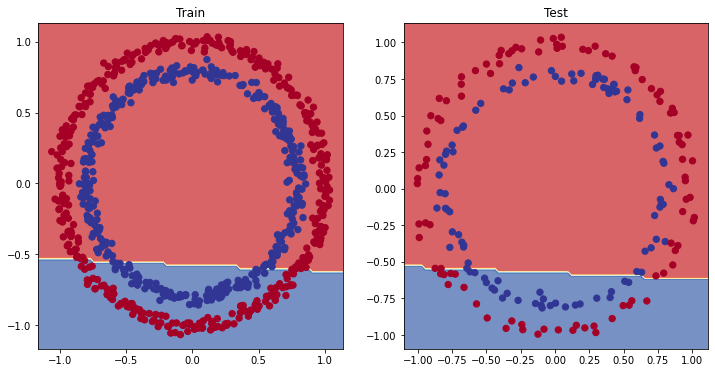

In [31]:
# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving the model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the modelm rather than the data.

And because these options are all values we (as ML engineers and data scientists) can change, they are referred to as **hyperparameters**.



Let's try to increase our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000


In [32]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create two nn.Linear layers that are capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)


    # 3. Define a forward() method that oulines the forward pass (or forward computation) of the model
    def forward(self, x):
        #z = self.layer_1(x)
        #z = self.layer_2(z)
        #z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # x -> (goes into) layer 1 -> layer 2 -> layer 3 -> output
                                                           # this way of writing operations speeds up things

# 4. Instatiate an istance of our model class and send it to the target device

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Setup the loss function
#loss_fn = nn.BCEWLoss() # BCEWLoss = Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built=in
                                 # This version is more numerically stable than using a plain Sigmoid followed by a BCELoss

# Setup the optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.01)

# Calculate accuracy - out of a 100 examples what % does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimizer (gradient descent)
    optimizer.step()


    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396, Acc: 50.875000% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69369, Acc: 50.250000% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 200 | Loss: 0.69351, Acc: 50.125000% | Test loss: 0.69282, Test acc: 49.50%
Epoch: 300 | Loss: 0.69339, Acc: 50.500000% | Test loss: 0.69295, Test acc: 49.00%
Epoch: 400 | Loss: 0.69329, Acc: 50.375000% | Test loss: 0.69309, Test acc: 48.50%
Epoch: 500 | Loss: 0.69322, Acc: 49.875000% | Test loss: 0.69322, Test acc: 49.50%
Epoch: 600 | Loss: 0.69317, Acc: 49.500000% | Test loss: 0.69335, Test acc: 53.00%
Epoch: 700 | Loss: 0.69313, Acc: 49.375000% | Test loss: 0.69347, Test acc: 50.50%
Epoch: 800 | Loss: 0.69309, Acc: 50.000000% | Test loss: 0.69358, Test acc: 51.00%
Epoch: 900 | Loss: 0.69307, Acc: 50.625000% | Test loss: 0.69368, Test acc: 47.50%


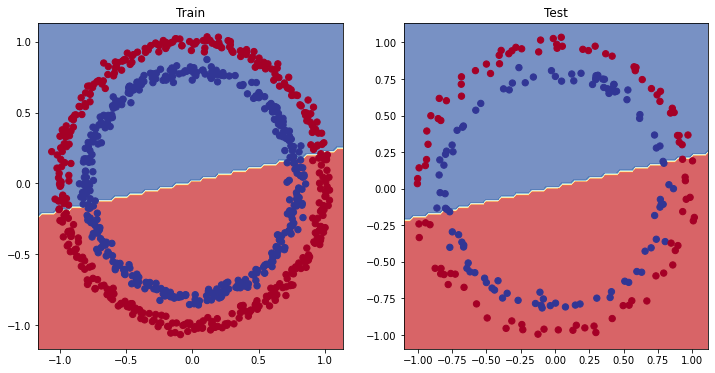

In [35]:
# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test on a smaller problem.

In [36]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [37]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

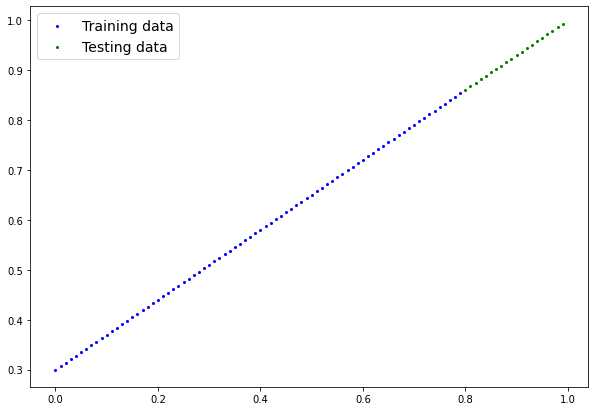

In [38]:
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjusting `model_1` to fit a straight line


In [39]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                            lr=0.01)

In [41]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    model_2.train()
    
    y_pred = model_2(X_train_regression)

    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()    

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)

        test_loss = loss_fn(test_pred, y_test_regression) 

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


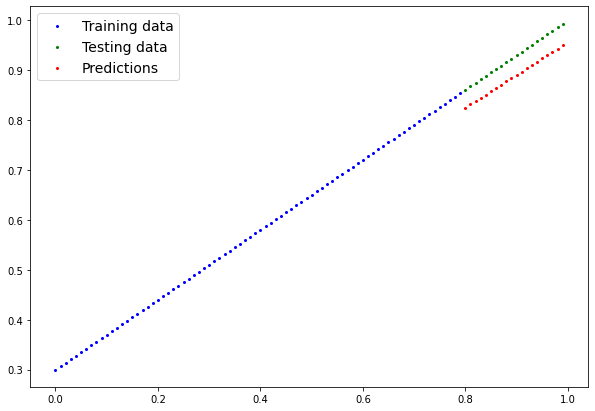

In [42]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(), 
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity
"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)


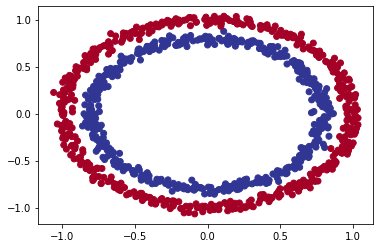

In [43]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [44]:
# Convert data to tensors and then to train and test splits 
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) 
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42) 

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear = straight lines
* Non-linear = non-straight lines


Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [45]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function
    
  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(), 
                            lr = 0.1)

### 6.3 Training a model with non-linearity

In [47]:
# Random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1500

for epoch in range(epochs):
    ### Training
    model_3.train() 

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels 

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()   

    # 4. Loss backward
    loss.backward() 

    # 5. Step the optimizer
    optimizer.step()    

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
    
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                               y_pred=test_pred)

    # Print out what's this happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")  

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%
Epoch: 1000 | Loss: 0.5682, Acc: 87.75% | Test Loss: 0.5738, Test Acc: 86.50%
Epoch: 1100 | Loss: 0.4815, Acc: 93.50% | Test Loss: 0.4993, Test Acc: 90.50%
Epoch: 1200 | Loss: 0.3706, Acc: 97.75% | Test Loss: 0.4059, Test Acc: 92.00

### 6.4 Evaluating a model trained with non-linear activation functions



In [48]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

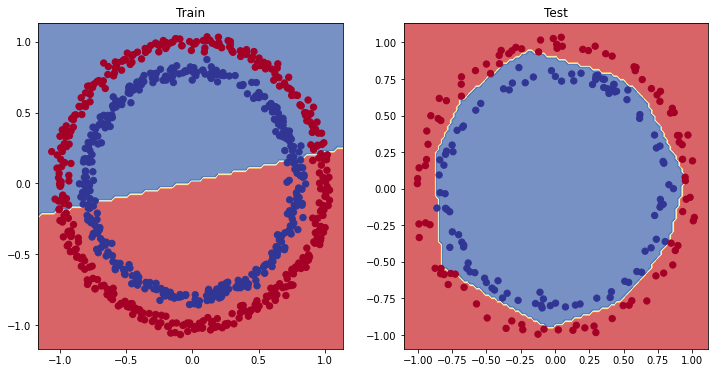

In [49]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linaer functions.

In [50]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [51]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

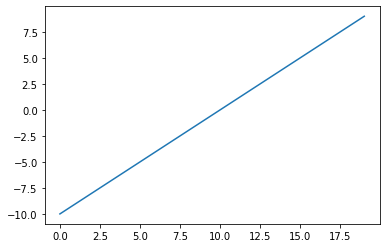

In [52]:
# Visualize the tensor
plt.plot(A);

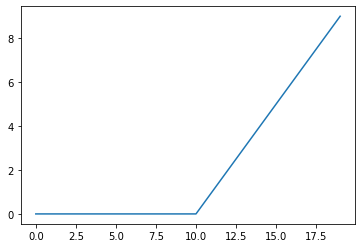

In [53]:
plt.plot(torch.relu(A));

In [54]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

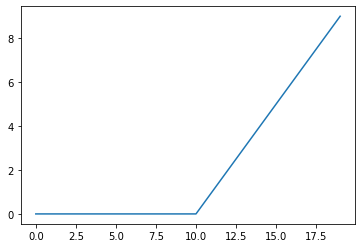

In [55]:
# Plot ReLU activation function
plt.plot(relu(A));

In [56]:
# Now let's do the same for Sigmoid = https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid 
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

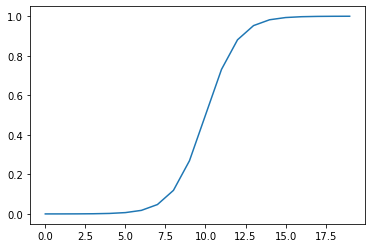

In [57]:
plt.plot(torch.sigmoid(A));

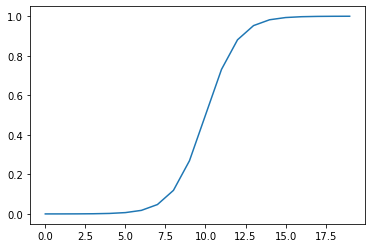

In [58]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem
* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

[[-8.41339595  6.93516545]
 [-5.76648413 -6.43117072]
 [-6.04213682 -6.76610151]
 [ 3.95083749  0.69840313]
 [ 4.25049181 -0.28154475]] <class 'numpy.ndarray'> float64
[3 2 2 1 1] <class 'numpy.ndarray'> int64
tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) <class 'torch.Tensor'> torch.float32
tensor([3, 2, 2, 1, 1]) <class 'torch.Tensor'> torch.int64


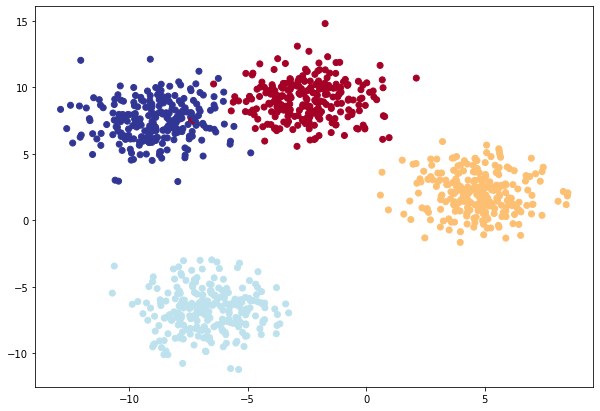

In [59]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs 
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)
print(X_blob[:5], type(X_blob), X_blob.dtype)
print(y_blob[:5], type(y_blob), y_blob.dtype)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], type(X_blob), X_blob.dtype)
print(y_blob[:5], type(y_blob), y_blob.dtype)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


### 8.2 Building a multi-class classification model in PyTorch


In [60]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [61]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an iptimizer for a multi-class classification model

In [62]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(), 
                            lr=0.1) # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model
In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [63]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10], y_blob_test[:10]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834],
         [-0.1497, -1.0617, -0.7107, -0.1645],
         [ 0.1539, -0.2887,  0.1520, -0.0109],
         [-0.2154, -1.1795, -0.9300, -0.2745],
         [ 0.2443, -0.2472,  0.1649,  0.0061],
         [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [64]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [65]:
# Convert our model's prediction probabilities to prediction labels - argmax
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [66]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs 
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    ### Training 
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)
      
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model


In [67]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Go from pred probs -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)


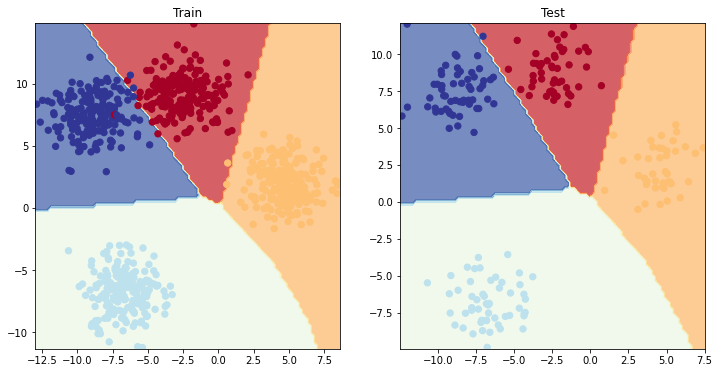

In [68]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)
* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/

In [69]:
%%capture
!pip install torchmetrics

In [73]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculuate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [74]:
torchmetric_accuracy.device

device(type='cuda', index=0)